In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')   ##This is in order, so label 0 refers to plane, 1 to a car and so on

Files already downloaded and verified


In [42]:
image,label=trainset[0]

In [7]:
image.shape

torch.Size([3, 32, 32])

LABEL:  frog


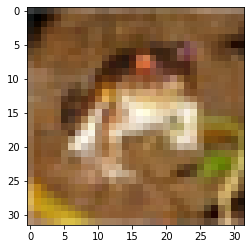

In [43]:
## Lets define a function that can print a particular image. Lets print the above image variable that has the first image
def showimage(img,label):
    img = img / 2 + 0.5     # unnormalize
    img = img.permute(1,2,0)   ##Converts image to H X W X C. = 32 X 32 X 3 . WE have to put channels last for matplotlib
    plt.imshow(img)
    print("LABEL: ",classes[label])

showimage(image,label)


Lets define a CNN class now


In [48]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        ##Fully connectd layers below
        self.fc1=nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2=nn.Linear(in_features=120, out_features=60)
        self.out=nn.Linear(in_features=60, out_features=10)  
        
    def forward(self,t):
        ##Input layer
        t=t
        
        ##First layer of CONV2D
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        ##Second layer of CONV2D
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        
        ## Fully connected linear layer
           ## (n-f+2p)/s +1
            #n=32, f = 5 , s=1.    (32 -5 +0 )/1 + 1 = 28  :Image size after 1st conv
            #n=28, f=2, s =2.   (28 -2 +0)/2 +1 = 14     : Image size after 1st maxpool
            #n=14, f=5, s=1. (14-5+0)/1 +1 = 10        :Image size after 2nd conv
            #n=10, f=2, s=2. (10-2+0)/2 + 1 = 5     : Image size after 2nd maxpool
            #So after 2 convolutions and 2 maxpools we will get an image of H X W = 5 X 5  and with 16 channels, so 16 X 5 X 5
            
        t=t.view(-1,16*5*5) 
        t=self.fc1(t)
        t=self.fc2(t)
        t=self.out(t)
        
        return t
    

In [49]:
net=Net()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [50]:
for epoch in range(2):
    running_loss=0.
    for i , data in enumerate(trainloader,0):
        images, labels=data
        optimizer.zero_grad()
        output=net(images)
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
    

[1,  2000] loss: 2.126
[1,  4000] loss: 1.769
[1,  6000] loss: 1.598
[1,  8000] loss: 1.539
[1, 10000] loss: 1.492
[1, 12000] loss: 1.471
[2,  2000] loss: 1.404
[2,  4000] loss: 1.380
[2,  6000] loss: 1.376
[2,  8000] loss: 1.368
[2, 10000] loss: 1.332
[2, 12000] loss: 1.340
Finished Training


In [51]:
### Lets save the training data
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Since our model is trained, its time we try it out on test data. Lets print a  sample

Files already downloaded and verified
LABEL:  cat


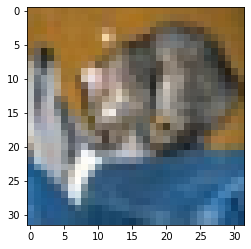

In [58]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

image,label= next(iter(testset))
showimage(image,label)


In [63]:
print(image.shape)


torch.Size([3, 32, 32])


Lets run our network on our first test set batch

In [67]:
images,labels=next(iter(testloader))
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)   ##Sending our first batch from test set to our model
print(outputs)
print(outputs.argmax(dim=1))   ## Printing the highest number's index in every row

tensor([[ 1.2211e-01, -2.0671e+00,  1.4990e+00,  2.4642e+00,  9.4043e-01,
          1.4821e+00,  8.1222e-01, -1.7283e+00, -1.4111e-01, -1.3012e+00],
        [ 3.5573e+00,  4.1891e+00, -1.6558e+00, -2.9955e+00, -3.1092e+00,
         -4.0829e+00, -4.3591e+00, -4.9990e+00,  6.6877e+00,  3.7271e+00],
        [ 1.4577e+00,  1.5139e+00,  1.5425e-01, -7.5935e-01, -5.1204e-01,
         -1.8926e+00, -1.1575e+00, -2.2370e+00,  1.5476e+00,  3.8285e-01],
        [ 2.9062e+00,  3.1709e-01, -5.8592e-03, -1.4132e+00, -6.5253e-01,
         -1.6187e+00, -2.5015e+00, -8.2587e-01,  3.0745e+00,  6.7825e-03]],
       grad_fn=<AddmmBackward>)
tensor([3, 8, 8, 8])


In [69]:
print (labels)   ##These are the actual labels. So we had 3 correct and 1 wrong

tensor([3, 8, 8, 0])


We can even compare the predicted output to the actual labels with this 

In [74]:
output=outputs.argmax(dim=1)
print(output)
print (labels)

# Now we  have to compare output to labels
compare=output.eq(labels)
print(compare)
print(compare.sum().item())    ## So we have 3 correct predictions

tensor([3, 8, 8, 8])
tensor([3, 8, 8, 0])
tensor([ True,  True,  True, False])
3


In [76]:
len(trainset)

50000

In [77]:
# Lets test it on the complete test batches
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


Lets find out the accuracy of every class

In [83]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels=data
        output=net(images)
        pred=output.argmax(dim=1)
        c=pred.eq(labels)
        for i in range(4):     ## Because the batch size is 4
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
for i in range(10):
    print("Accuracy of ", classes[i], " : ", class_correct[i]*100/class_total[i] )

Accurac of  plane  :  60.9
Accurac of  car  :  67.4
Accurac of  bird  :  63.3
Accurac of  cat  :  25.5
Accurac of  deer  :  29.1
Accurac of  dog  :  39.6
Accurac of  frog  :  72.3
Accurac of  horse  :  60.3
Accurac of  ship  :  70.0
Accurac of  truck  :  47.7
